In [36]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import pandas as pd
import os
import h5py
import os
from scipy.stats import gaussian_kde



plt.style.use('seaborn-v0_8-darkgrid')


In [37]:
TITLE_SIZE = 18
TITLE_PAD = 15
LABEL_SIZE = 14
LEGEND_SIZE = 16
FIG_X_SIZE = 10
FIG_Y_SIZE = 6
PLOT_WIDTH = 2
TICK_SIZE = 12

MAIN_LINE_COLOR = "#005f73"
MAIN_FILL_COLOR = "#2aad8f"

SECOND_LINE_COLOR = "#1b3240"
SECOND_FILL_COLOR = "#264653"

THIRTH_LINE_COLOR = "#b89e3c"
THIRTH_FILL_COLOR = "#e9c46a"

FOURTH_LINE_COLOR = "#b34a3d"
FOURTH_FILL_COLOR = "#e76f51"


RED_LINE_COLOR = '#6a0000'
RED_FILL_COLOR = '#f9a6a6'

BLUE_LINE_COLOR = '#003d4d'
BLUE_FILL_COLOR = '#a6dee3'

GREEN_LINE_COLOR = '#093e00'
GREEN_FILL_COLOR = '#81d784'

### Importação dos dados

In [43]:
class Load_Data:
    def __init__(self,file,var_name,n_data_in_file):
        self.path = file
        self.var_name = var_name
        self.n_data_in_file = n_data_in_file
        self.loadData()



    def loadData(self):
        self.episodic_data = []
        with h5py.File(self.path, 'r') as f:
            total_datasets = len(f.keys())
            for i in range(int(total_datasets / self.n_data_in_file)):
                episodic_data = f[f"{self.var_name}{i+1}"]
                # if self.var_name == "loss_":
                #     mse_data = np.array(f[f"mse_{i+1}"])
                #     corrected_data = episodic_data - 0.5 * mse_data
                #     self.episodic_data.append(corrected_data)
                # else:
                self.episodic_data.append(np.array(episodic_data))
    
    def get_maxs_list(self):
        return np.array([data.max() for data in self.episodic_data])
    def get_mins_list(self):
        return np.array([data.min() for data in self.episodic_data])
    def get_mean_list(self):
        return np.array([data.mean() for data in self.episodic_data])
    def get_std_deviation_step(self):
        return np.array([np.std(data) for data in self.episodic_data])


    def get_moving_mean_episode(self,window):
        return np.convolve(self.episodic_data, np.ones(window)/window, mode='valid')
    def get_std_deviation_episode(self,window):
        return [np.std(self.episodic_data[i:i+window]) for i in range(len(self.episodic_data) - window + 1)]



In [44]:
# cg_inside =         Load_Data("/home/victor/tg_proj/Misc.h5","y_",4)
# poligon_area =      Load_Data("/home/victor/tg_proj/Misc.h5","x_",4)
# end_cause =         Load_Data("/home/victor/tg_proj/EndCause.h5","info_",1)

# vx =                Load_Data("/home/victor/tg_proj/Speeds.h5","vx_",3)
# vy =                Load_Data("/home/victor/tg_proj/Speeds.h5","vy_",3)
# vz =                Load_Data("/home/victor/tg_proj/Speeds.h5","vz_",3)

# roll =              Load_Data("/home/victor/tg_proj/RPY.h5","roll_",3)
# pitch =             Load_Data("/home/victor/tg_proj/RPY.h5","pitch_",3)
# yaw =               Load_Data("/home/victor/tg_proj/RPY.h5","yaw_",3)
# correct_direction = Load_Data("/home/victor/tg_proj/Misc.h5","z_",4)


function_loss =     Load_Data("/home/victor/tg_proj/models/Losses.h5","loss_",2)
mse =               Load_Data("/home/victor/tg_proj/models/Losses.h5","mse_",2)

### Análise de posições

In [368]:
def plot_heatmap(x, y, ax):    
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)

    # Limites fixos
    xmin, xmax = -30, 0
    ymin, ymax = -2.5, 2.5

    # Criação de uma grade para avaliar a densidade
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    f = kde(positions).reshape(xx.shape)

    contour = ax.contourf(xx, yy, f, levels=100, cmap='jet')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    return contour

In [ ]:



GAP = 500

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # facilita o acesso com índice único

x_buffer = []
y_buffer = []
plot_index = 0

with h5py.File('/home/victor/tg_proj/models/Positions.h5', 'r') as f:
    total_datasets = len(f.keys())
    print(f"Total de vetores (datasets) na raiz: {total_datasets / 3}")

    for i in range(int(total_datasets / 3)):
        x_buffer.extend(f[f"x_{i+1}"])
        y_buffer.extend(f[f"y_{i+1}"])

        if i % GAP == 0 and i != 0:
            if plot_index < len(axes):
                ax = axes[plot_index]
                contour = plot_heatmap(x_buffer, y_buffer, ax)
                ax.set_title(f'Episódios: {plot_index*GAP} - {(plot_index+1)*GAP}', fontweight='bold')
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_aspect('equal')
                plot_index += 1
                contour_for_cbar = contour
            x_buffer.clear()
            y_buffer.clear()
fig.suptitle('Mapas de Densidade de Posição', fontsize=16, fontweight='bold')

if contour_for_cbar:
    cbar_ax = fig.add_axes([0.25, 0.03, 0.5, 0.02])  # [left, bottom, width, height]
    cbar = fig.colorbar(contour_for_cbar, cax=cbar_ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=9)

fig.suptitle('Mapas de Posições', fontsize=18, fontweight='bold')

plt.tight_layout(rect=[0, 0.05, 1, 0.93])
plt.show()



Total de vetores (datasets) na raiz: 2116.0


### Função de perda

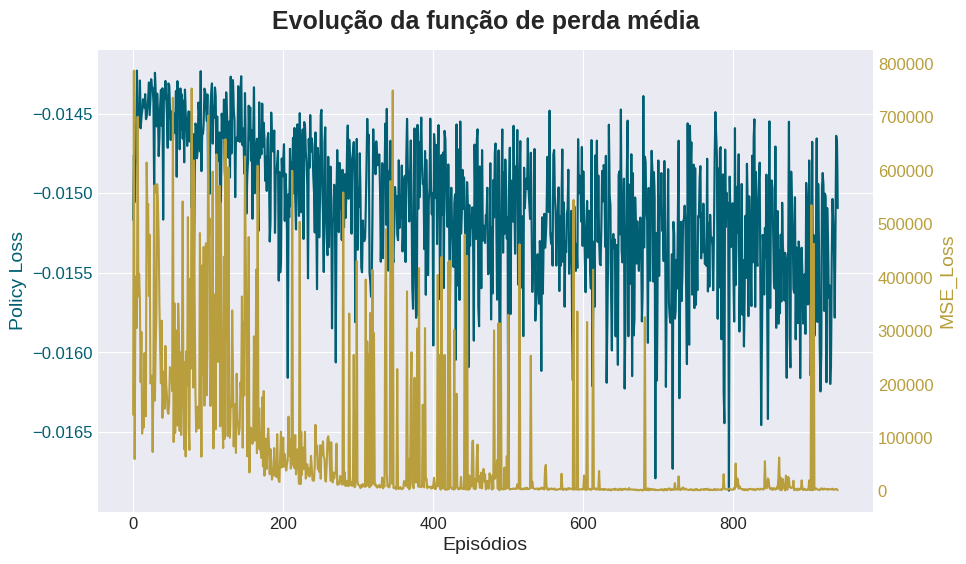

In [45]:
fig, ax = plt.subplots(figsize=(FIG_X_SIZE, FIG_Y_SIZE))
steps = range(len(function_loss.get_mean_list()))
ax2 = ax.twinx()

ax.plot(steps, function_loss.get_mean_list(), label='Função de perda (principal)', color=MAIN_LINE_COLOR)
ax2.plot(steps, mse.get_mean_list(), label='Função de perda (secundária)', color=THIRTH_LINE_COLOR)

ax.fill_between(steps, function_loss.get_mins_list(), function_loss.get_maxs_list(), color=MAIN_LINE_COLOR, alpha=0.2)

ax.set_title('Evolução da função de perda média', fontsize=TITLE_SIZE, fontweight='bold', pad=TITLE_PAD)
ax.set_xlabel('Episódios', fontsize=LABEL_SIZE)

# Colore os labels e ticks de cada eixo com a cor da linha correspondente
ax.set_ylabel('Policy Loss', fontsize=LABEL_SIZE)
ax.yaxis.label.set_color(MAIN_LINE_COLOR)
ax.tick_params(axis='y', colors=MAIN_LINE_COLOR)

ax2.set_ylabel('MSE_Loss', fontsize=LABEL_SIZE)
ax2.yaxis.label.set_color(THIRTH_LINE_COLOR)
ax2.tick_params(axis='y', colors=THIRTH_LINE_COLOR)

ax.tick_params(axis='x', labelsize=TICK_SIZE)
ax.tick_params(axis='y', labelsize=TICK_SIZE)
ax2.tick_params(axis='y', labelsize=TICK_SIZE)

ax.set_axisbelow(True)
ax2.grid(False)

plt.show()



In [ ]:


# Inicializa listas
loss_means, loss_max, loss_mins = [], [], []
mse_means, mse_max, mse_mins = [], [], []
yaw_means, yaw_max, yaw_mins = [], [], []

direction_means, direction_max, direction_mins = [], [], []

# Lê os dados
with h5py.File('/home/victor/tg_proj/models/Losses.h5', 'r') as f:
    total_datasets = len(f.keys())
    print(f"Total de vetores (datasets) na raiz: {total_datasets / 3}")
    print(f.keys())
    for i in range(int(total_datasets / 4)):
        loss = f[f"loss_{i+1}"][:]
        mse = f[f"mse_{i+1}"][:]

        loss_means.append(np.mean(loss))
        loss_max.append(np.max(loss))
        loss_mins.append(np.min(loss))

        mse_means.append(np.mean(mse))
        mse_max.append(np.max(mse))
        mse_mins.append(np.min(mse))





steps = range(len(loss_means))

plt.style.use('seaborn-v0_8-darkgrid')
fig, axs = plt.subplots(2, 1, figsize=(FIG_X_SIZE, FIG_Y_SIZE), sharex=True)

def plot_subplot(ax, mean, mins, maxs, color_line, color_fill, label):
    ax.plot(steps, mean, color=color_line, label=label, linewidth=2)
    ax.fill_between(steps, mins, maxs, color=color_fill, alpha=0.25)
    ax.set_ylabel(f'{label} (m/s)', fontsize=12)
    ax.legend(loc='upper right', fontsize=10)
    ax.tick_params(axis='both', labelsize=10)

# Subplot 1: vx
plot_subplot(axs[0], loss_means, loss_mins, loss_max, '#6a0000', '#f9a6a6', 'vx')
axs[0].axhline(0.2)


# Subplot 2: vy
plot_subplot(axs[1], mse_means, mse_mins, mse_max, '#093e00', '#81d784', 'vy')




axs[1].set_xlabel('Episódios', fontsize=14)
fig.suptitle('Evolução das velocidades do robô (vx, vy, vz)', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Total de vetores (datasets) na raiz: 1451.3333333333333
<KeysViewHDF5 ['loss_1402', 'loss_1403', 'loss_1404', 'loss_1405', 'loss_1406', 'loss_1407', 'loss_1408', 'loss_1409', 'loss_1410', 'loss_1411', 'loss_1412', 'loss_1413', 'loss_1414', 'loss_1415', 'loss_1416', 'loss_1417', 'loss_1418', 'loss_1419', 'loss_1420', 'loss_1421', 'loss_1422', 'loss_1423', 'loss_1424', 'loss_1425', 'loss_1426', 'loss_1427', 'loss_1428', 'loss_1429', 'loss_1430', 'loss_1431', 'loss_1432', 'loss_1433', 'loss_1434', 'loss_1435', 'loss_1436', 'loss_1437', 'loss_1438', 'loss_1439', 'loss_1440', 'loss_1441', 'loss_1442', 'loss_1443', 'loss_1444', 'loss_1445', 'loss_1446', 'loss_1447', 'loss_1448', 'loss_1449', 'loss_1450', 'loss_1451', 'loss_1452', 'loss_1453', 'loss_1454', 'loss_1455', 'loss_1456', 'loss_1457', 'loss_1458', 'loss_1459', 'loss_1460', 'loss_1461', 'loss_1462', 'loss_1463', 'loss_1464', 'loss_1465', 'loss_1466', 'loss_1467', 'loss_1468', 'loss_1469', 'loss_1470', 'loss_1471', 'loss_1472', 'loss_

KeyError: "Unable to synchronously open object (object 'loss_1' doesn't exist)"

### Função de recompensa

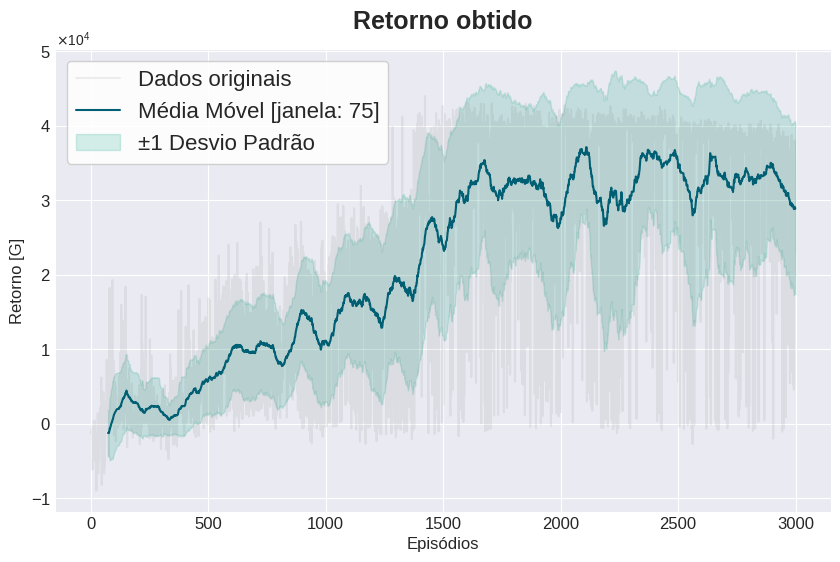

In [ ]:

dados = rewards_sum[:3000]
janela = 75

color1 = "#666666"
color_line = "#005f73"
color_fill = "#2aad8f"




media_movel = np.convolve(dados, np.ones(janela)/janela, mode='valid')

desvios = [np.std(dados[i:i+janela]) for i in range(len(dados) - janela + 1)]
media_movel = np.array(media_movel)
desvios = np.array(desvios)

limite_superior = media_movel + desvios
limite_inferior = media_movel - desvios

fig, ax = plt.subplots(figsize=(FIG_X_SIZE, FIG_Y_SIZE))
ax.plot(dados, label='Dados originais',color = color1, alpha=0.1)
ax.plot(range(janela-1, len(dados)), media_movel, label=f'Média Móvel [janela: {janela}]', color=color_line)
ax.fill_between(range(janela-1, len(dados)), limite_inferior, limite_superior,
                 color=color_fill, alpha=0.2, label='±1 Desvio Padrão')
ax.legend(loc='upper left', fontsize=LEGEND_SIZE, frameon=True, framealpha=0.9, facecolor='white')

ax.set_title('Retorno obtido',fontweight='bold', fontsize = TITLE_SIZE, pad=TITLE_PAD)
ax.set_xlabel('Episódios',fontsize = 12)
ax.set_ylabel('Retorno [G]',fontsize =12)
ax.tick_params(axis='both', labelsize=12)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.grid(True)


### Área do poligono da base e porcentagem de tempo com o cg dentro dele

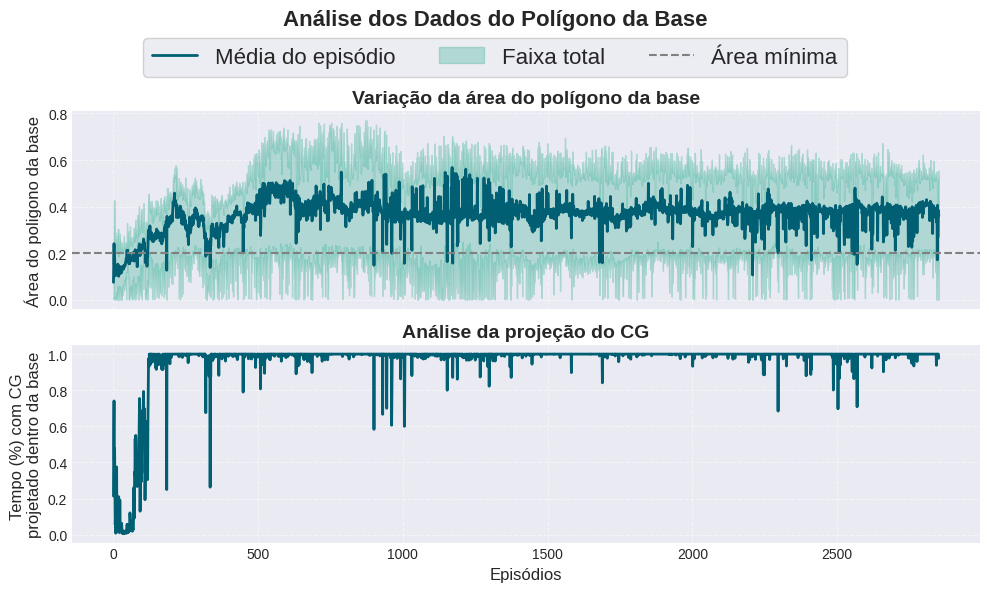

In [180]:

steps = range(len(area_means))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(FIG_X_SIZE, FIG_Y_SIZE), sharex=True)

def plot_subplot(ax, mean):
    ax.plot(steps, mean, color=MAIN_LINE_COLOR, linewidth=2, label = 'Média do episódio')
    
    ax.tick_params(axis='both', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)

# Subplot 1: vx
plot_subplot(ax1, area_means)
ax1.fill_between(steps, area_mins, area_max, color=MAIN_FILL_COLOR, alpha=0.3, label='Faixa total')
ax1.set_title("Variação da área do polígono da base", fontsize=14, fontweight='bold')
ax1.axhline(0.2, linestyle='--', color='gray', linewidth=1.5, label='Área mínima')
ax1.set_ylabel(f'Área do poligono da base', fontsize=12)

# Subplot 2: vy
plot_subplot(ax2, inside_means)
ax2.set_title("Análise da projeção do CG", fontsize=14, fontweight='bold')
ax2.set_xlabel('Episódios', fontsize=12)
ax2.set_ylabel(f'Tempo (%) com CG \nprojetado dentro da base', fontsize=12)


# Título geral
fig.suptitle('Análise dos Dados do Polígono da Base', fontsize=16, fontweight='bold')
handles, labels = ax1.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=LEGEND_SIZE, frameon=True, framealpha=0.9,bbox_to_anchor=(0.5, 0.95))
plt.tight_layout(rect=[0, 0, 1, 0.93])

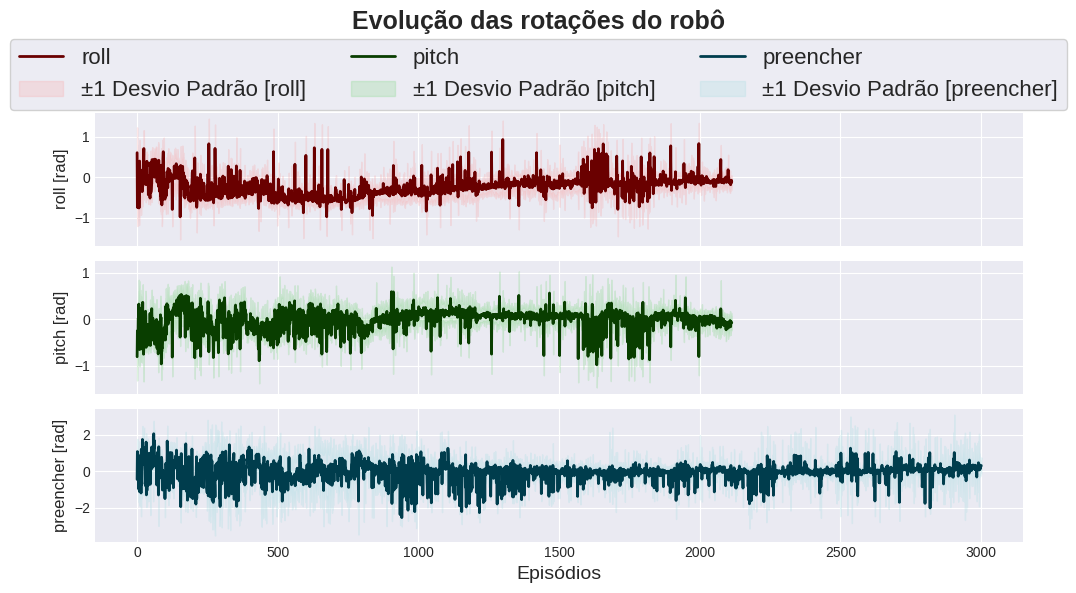

In [23]:

fig, axs = plt.subplots(3, 1, figsize=(FIG_X_SIZE, FIG_Y_SIZE), sharex=True)

def plot_subplot(ax, mean, mins, maxs, color_line, color_fill, label):
    ax.plot(mean, color=color_line, label=label, linewidth=2)
    ax.fill_between(range(len(mean)), mins, maxs, color=color_fill, alpha=0.25,label = f'±1 Desvio Padrão [{label}]')
    ax.set_ylabel(f'{label} [rad]', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

# Subplot 1: vx
plot_subplot(axs[0], roll.get_mean_list(),
             roll.get_mean_list() - roll.get_std_deviation_step(),
             roll.get_mean_list() + roll.get_std_deviation_step(),
             RED_LINE_COLOR, RED_FILL_COLOR, 'roll')

# Subplot 2: vy
plot_subplot(axs[1], pitch.get_mean_list(),
             pitch.get_mean_list() - pitch.get_std_deviation_step(),
             pitch.get_mean_list() + pitch.get_std_deviation_step(),
             GREEN_LINE_COLOR, GREEN_FILL_COLOR, 'pitch')

# Subplot 2: vy
plot_subplot(axs[2], correct_direction.get_mean_list(),
             correct_direction.get_mean_list() - correct_direction.get_std_deviation_step(),
             correct_direction.get_mean_list() + correct_direction.get_std_deviation_step(),
             BLUE_LINE_COLOR, BLUE_FILL_COLOR, 'preencher')

# Pega legendas separadamente e junta
handles0, labels0 = axs[0].get_legend_handles_labels()
handles1, labels1 = axs[1].get_legend_handles_labels()
handles2, labels2 = axs[2].get_legend_handles_labels()

handles = handles0 + handles1 + handles2
labels = labels0 + labels1 + labels2

# Legenda geral no topo
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=LEGEND_SIZE,
           frameon=True, framealpha=0.9, bbox_to_anchor=(0.5, 0.95))

axs[2].set_xlabel('Episódios', fontsize=14)
fig.suptitle('Evolução das rotações do robô', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()



### Direção correta

### Velocidades vx,vy e vz

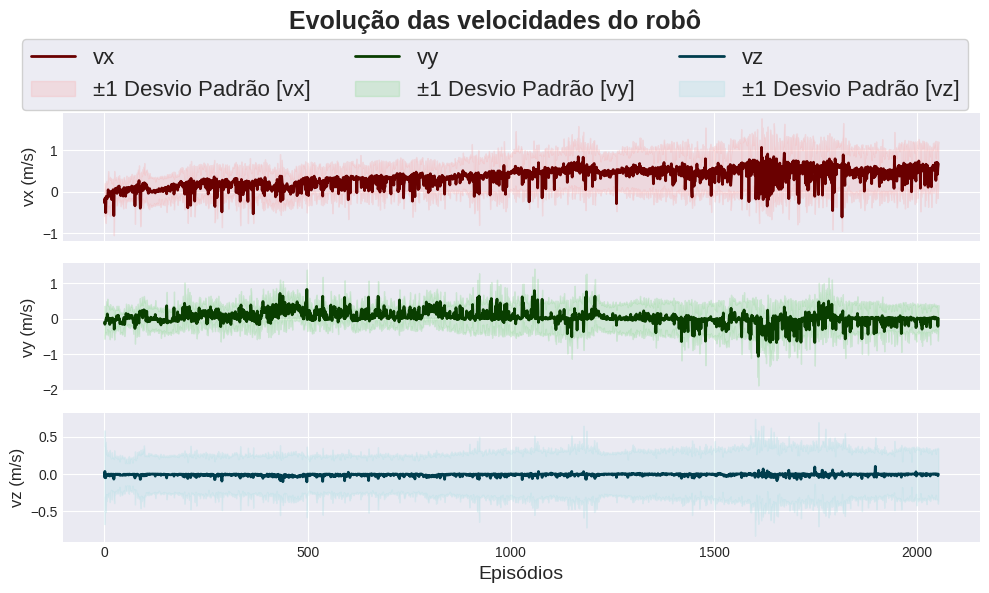

In [354]:

fig, axs = plt.subplots(3, 1, figsize=(FIG_X_SIZE, FIG_Y_SIZE), sharex=True)

def plot_subplot(ax, mean, mins, maxs, color_line, color_fill, label):
    ax.plot(mean, color=color_line, label=label, linewidth=2)
    ax.fill_between(range(len(mean)), mins, maxs, color=color_fill, alpha=0.25,label = f'±1 Desvio Padrão [{label}]')
    ax.set_ylabel(f'{label} (m/s)', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

# Subplot 1: vx
plot_subplot(axs[0], vx.get_mean_list(),
             vx.get_mean_list() - vx.get_std_deviation_step(),
             vx.get_mean_list() + vx.get_std_deviation_step(),
             '#6a0000', '#f9a6a6', 'vx')

# Subplot 2: vy
plot_subplot(axs[1], vy.get_mean_list(),
             vy.get_mean_list() - vy.get_std_deviation_step(),
             vy.get_mean_list() + vy.get_std_deviation_step(),
             '#093e00', '#81d784', 'vy')

# Subplot 3: vz
plot_subplot(axs[2], vz.get_mean_list(),
             vz.get_mean_list() - vz.get_std_deviation_step(),
             vz.get_mean_list() + vz.get_std_deviation_step(),
             '#003d4d', '#a6dee3', 'vz')

# Pega legendas separadamente e junta
handles0, labels0 = axs[0].get_legend_handles_labels()
handles1, labels1 = axs[1].get_legend_handles_labels()
handles2, labels2 = axs[2].get_legend_handles_labels()

handles = handles0 + handles1 + handles2
labels = labels0 + labels1 + labels2

# Legenda geral no topo
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=LEGEND_SIZE,
           frameon=True, framealpha=0.9, bbox_to_anchor=(0.5, 0.95))

axs[2].set_xlabel('Episódios', fontsize=14)
fig.suptitle('Evolução das velocidades do robô', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()



### Avaliação de altura

Total de vetores (datasets) na raiz: 2852.0


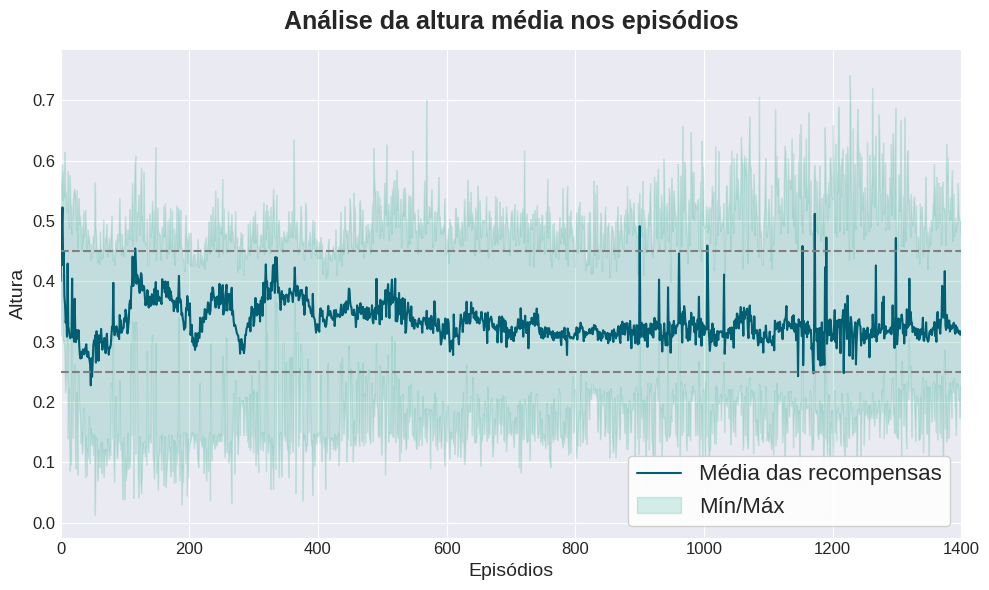

In [19]:
import numpy as np
import matplotlib.pyplot as plt

direction_means = []
z_max = []
z_mins = []


with h5py.File('/home/victor/tg_proj/backup2/Positions.h5', 'r') as f:
    total_datasets = len(f.keys())
    print(f"Total de vetores (datasets) na raiz: {total_datasets / 3}")
    for i in range(int(total_datasets / 3)):
        data = f[f"z_{i+1}"][:]  # lê o vetor como numpy array
        mean_val = np.mean(data)  # calcula a média do vetor
        max_val = np.max(data)  # calcula a média do vetor
        min_val = np.min(data)  # calcula a média do vetor
        
        direction_means.append(mean_val)
        z_max.append(max_val)
        z_mins.append(min_val)



plt.style.use('seaborn-v0_8-darkgrid')
color_line = "#005f73"
color_fill = "#2aad8f"
# color_line = "#4b0082"   # Indigo escuro
# color_fill = "#a98fd4"   # Lavanda suave
# color_line = "#264653"   # Azul petróleo
# color_fill = "#a8dadc"   # Azul-claro esverdeado
# color_line = "#014421"   # Verde floresta
# color_fill = "#81c784"   # Verde claro (tipo folha nova)
# color_line = "#7f3b00"   # Marrom avermelhado escuro
# color_fill = "#f4a261"   # Laranja claro terroso
# color_line = "#003844"   # azul petróleo profundo
# color_fill = "#2ec4b6"   # verde oceano claro
# color_line = "#014d40"   # verde profundo azulado
# color_fill = "#80ed99"   # verde menta suave
# color_line = "#002e4d"   # azul noite escuro
# color_fill = "#9ecae1"   # azul céu nebuloso
# color_line = "#1d3557"   # azul marinho com cinza
# color_fill = "#a8dadc"   # azul pálido acinzentado
# color_line = "#4b000f"   # vinho escuro
# color_fill = "#ffb3ab"   # coral claro pastel
# color_line = "#3e0066"   # púrpura escuro
# color_fill = "#cfaaff"   # lavanda pálida
# color_line = "#3e2c00"   # marrom escuro (terra)
# color_fill = "#e6d3a3"   # areia clara dourada
# color_line = "#2c2c54"   # cinza azulado escuro
# color_fill = "#fcbf49"   # laranja queimado suave
# color_line = "#254d00"   # verde musgo profundo
# color_fill = "#d4f4a3"   # verde lima pálido
# color_line = "#1a2a6c"   # azul meia-noite profundo
# color_fill = "#f6d365"   # dourado pastel
# color_line = "#2d2d2d"   # cinza carvão
# color_fill = "#ffcad4"   # rosa antigo suave
# color_line = "#006466"   # verde azulado escuro
# color_fill = "#ffa69e"   # salmão pastel
# color_line = "#3c003c"   # ameixa escuro profundo
# color_fill = "#d3bccc"   # lilás acinzentado pastel
# color_line = "#003f88"   # azul cobalto marcante
# color_fill = "#a8dadc"   # menta clara



fig, ax = plt.subplots(figsize=(FIG_X_SIZE, FIG_Y_SIZE))
plt.plot(range(len(direction_means)), direction_means, label='Média das recompensas', color=color_line)
plt.fill_between(range(len(direction_means)), z_mins, z_max, color=color_fill, alpha=0.2, label='Mín/Máx')
ax.hlines([0.25, 0.45], xmin=0, xmax=2000, colors='gray', linestyles='--')
ax.set_xlim([0,1400])
ax.set_title('Análise da altura média nos episódios', fontsize=18, fontweight='bold', pad=15)
ax.set_xlabel('Episódios', fontsize=14)
ax.set_ylabel('Altura', fontsize=14)
ax.legend(loc='lower right', fontsize=16, frameon=True, framealpha=0.9, facecolor='white')
ax.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

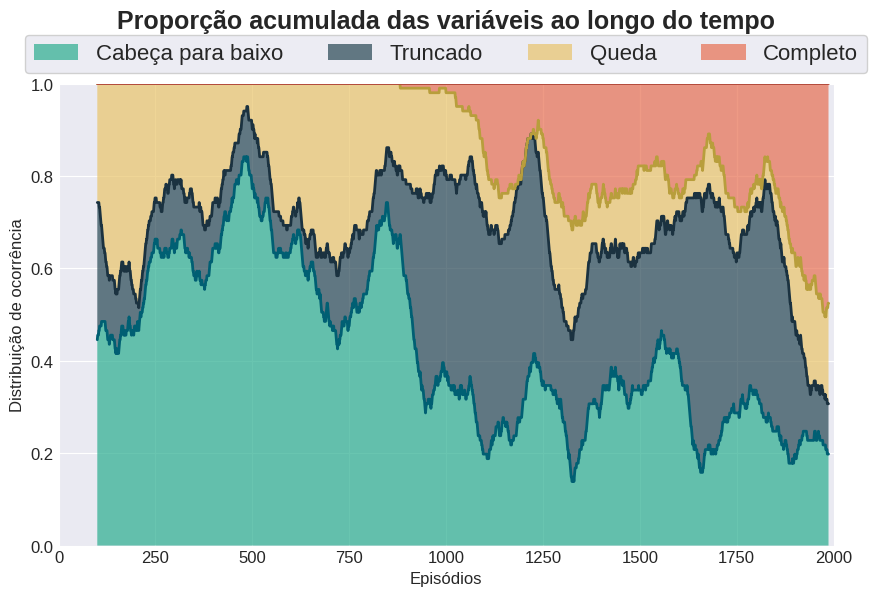

In [346]:
data = end_cause.episodic_data
data = np.array([o.item().decode("utf-8") for o in data])
data_series = pd.Series(data)
df = pd.DataFrame([
    data_series[i-100:i+1].value_counts() for i in range(len(data))
]).fillna(0).astype(int)

proporcoes = df.div(df.sum(axis=1), axis=0)
cores_fill = [
    MAIN_FILL_COLOR, SECOND_FILL_COLOR, THIRTH_FILL_COLOR, FOURTH_FILL_COLOR
]
cores_contorno = [
    MAIN_LINE_COLOR, SECOND_LINE_COLOR, THIRTH_LINE_COLOR, FOURTH_LINE_COLOR
]

proporcoes = proporcoes.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(FIG_X_SIZE, FIG_Y_SIZE))

ax.stackplot(proporcoes.index, proporcoes.T, labels=proporcoes.columns,
             colors=cores_fill, alpha=0.7)
cumulativas = proporcoes.cumsum(axis=1)

for i in range(len(proporcoes.columns)):
    ax.plot(proporcoes.index, cumulativas.iloc[:, i],
            color=cores_contorno[i], linewidth=2)

ax.set_title('Proporção acumulada das variáveis ao longo do tempo',
             fontsize=TITLE_SIZE, fontweight='bold', pad=40)

handles, labels = ax.get_legend_handles_labels()
labels = ["Cabeça para baixo","Truncado","Queda","Completo"]
ax.legend(handles, labels, loc='upper center', ncol=4, fontsize=LEGEND_SIZE,
          frameon=True, framealpha=0.9, bbox_to_anchor=(0.5, 1.13))

ax.set_ylim([0,1])
ax.set_xlim([0,2000])
ax.set_xlabel('Episódios', fontsize=12)
ax.set_ylabel(f'Distribuição de ocorrência', fontsize=12)
ax.tick_params(axis='both', labelsize=12)



/tmp/ipykernel_495614/3462314863.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/heatmap_proporcional.png'

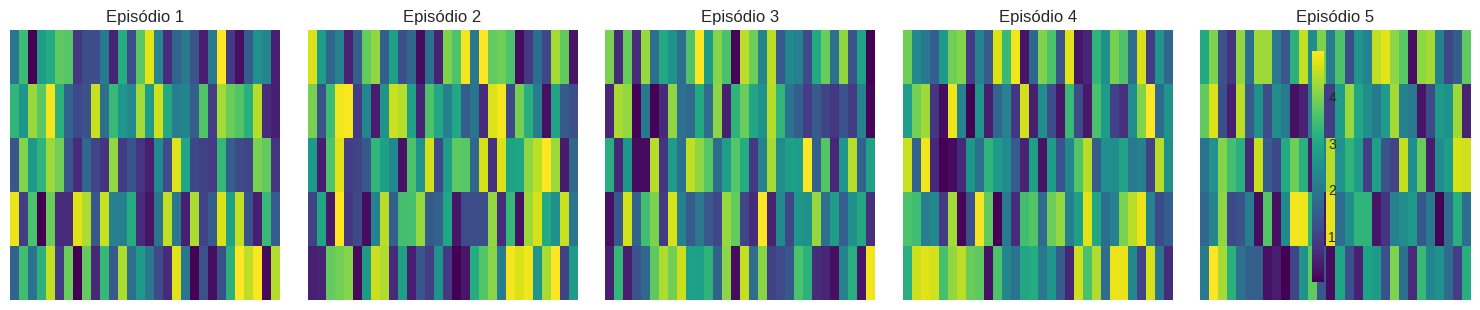

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Simulação dos dados
maps = [np.random.rand(5, 30) * i for i in range(1, 6)]

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axs):
    im = ax.imshow(maps[i], aspect=30/5, cmap='viridis')  # aspecto proporcional
    ax.set_title(f'Episódio {i+1}')
    ax.axis('off')

fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.savefig("/mnt/data/heatmap_proporcional.png", dpi=300)


/tmp/ipykernel_495614/342272758.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/heatmap_grid_proporcional.png'

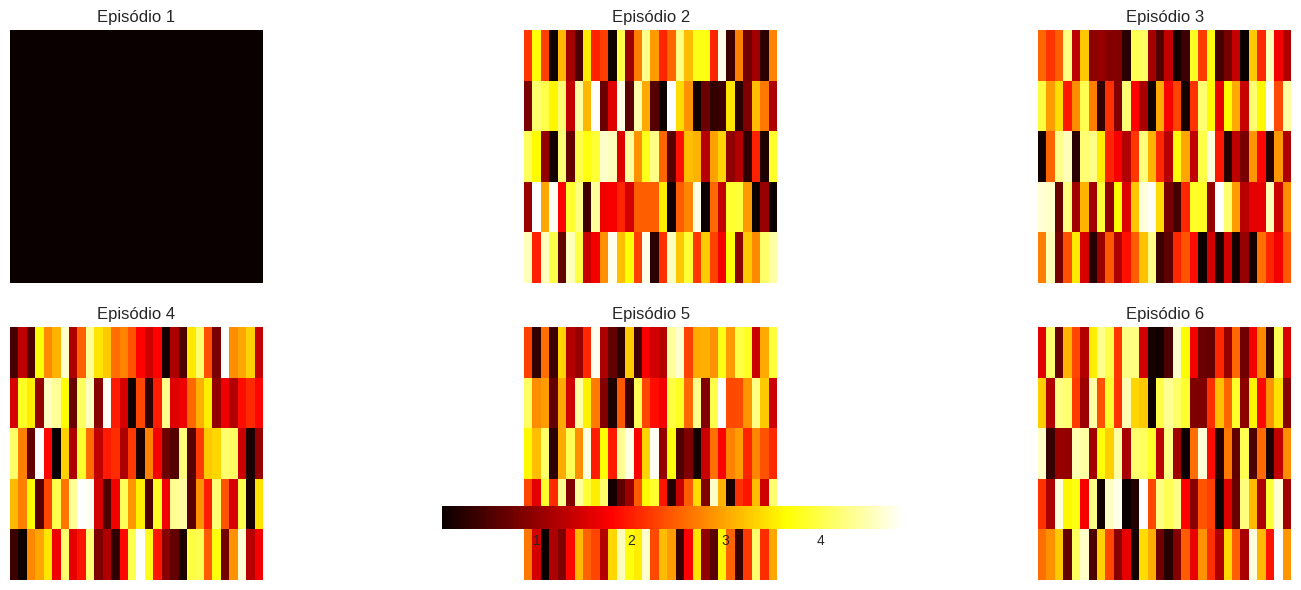

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(18, 6))

for i in range(6):
    data = np.random.rand(5, 30) * i
    ax = axs[i//3, i%3]
    im = ax.imshow(data, cmap='hot', aspect=30/5)
    ax.set_title(f'Episódio {i+1}')
    ax.axis('off')

fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.05)
plt.tight_layout()
plt.savefig("/mnt/data/heatmap_grid_proporcional.png", dpi=300)


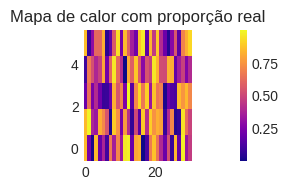

In [26]:
x = np.linspace(0, 30, 30)
y = np.linspace(0, 5, 5)
X, Y = np.meshgrid(x, y)
Z = np.random.rand(5, 30)

fig, ax = plt.subplots(figsize=(10, 2))
pcm = ax.pcolormesh(X, Y, Z, cmap='plasma', shading='auto')
ax.set_aspect(30/5)
fig.colorbar(pcm, ax=ax)
plt.title("Mapa de calor com proporção real")
plt.tight_layout()

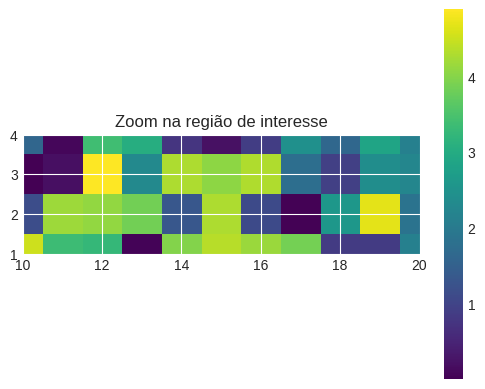

In [27]:
fig, ax = plt.subplots()
im = ax.imshow(data, aspect='equal', cmap='viridis')
ax.set_xlim(10, 20)  # foco horizontal
ax.set_ylim(1, 4)    # foco vertical
ax.set_title("Zoom na região de interesse")
plt.colorbar(im, ax=ax)


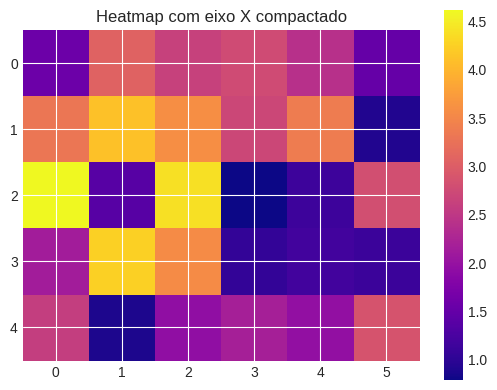

In [28]:
from scipy.ndimage import zoom
data_scaled = zoom(data, (1, 0.2))  # reduz eixo X
plt.imshow(data_scaled, cmap='plasma')
plt.title("Heatmap com eixo X compactado")
plt.colorbar()


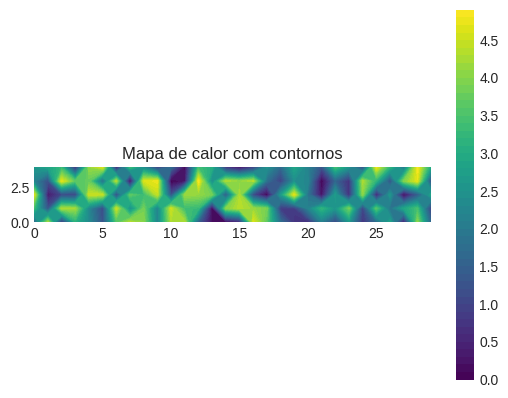

In [29]:
plt.contourf(data, levels=50, cmap='viridis')
plt.gca().set_aspect('equal')
plt.title("Mapa de calor com contornos")
plt.colorbar()


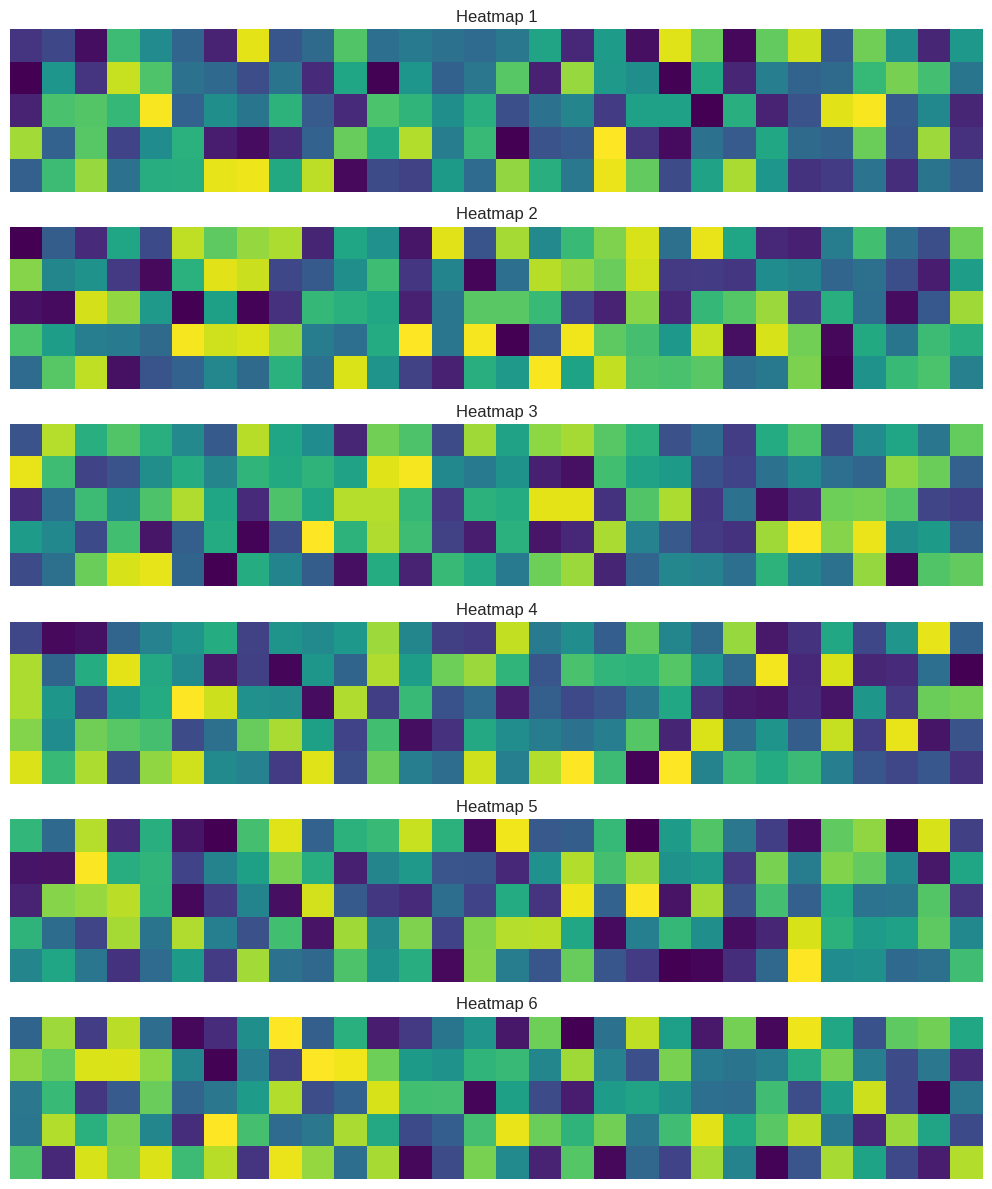

In [31]:
n_rows = 6
fig, axs = plt.subplots(n_rows, 1, figsize=(12, 2 * n_rows))  # altura baixa

for i in range(n_rows):
    data = np.random.rand(5, 30)
    im = axs[i].imshow(data, aspect='equal', cmap='viridis')
    axs[i].set_title(f"Heatmap {i+1}")
    axs[i].axis('off')

fig.tight_layout()


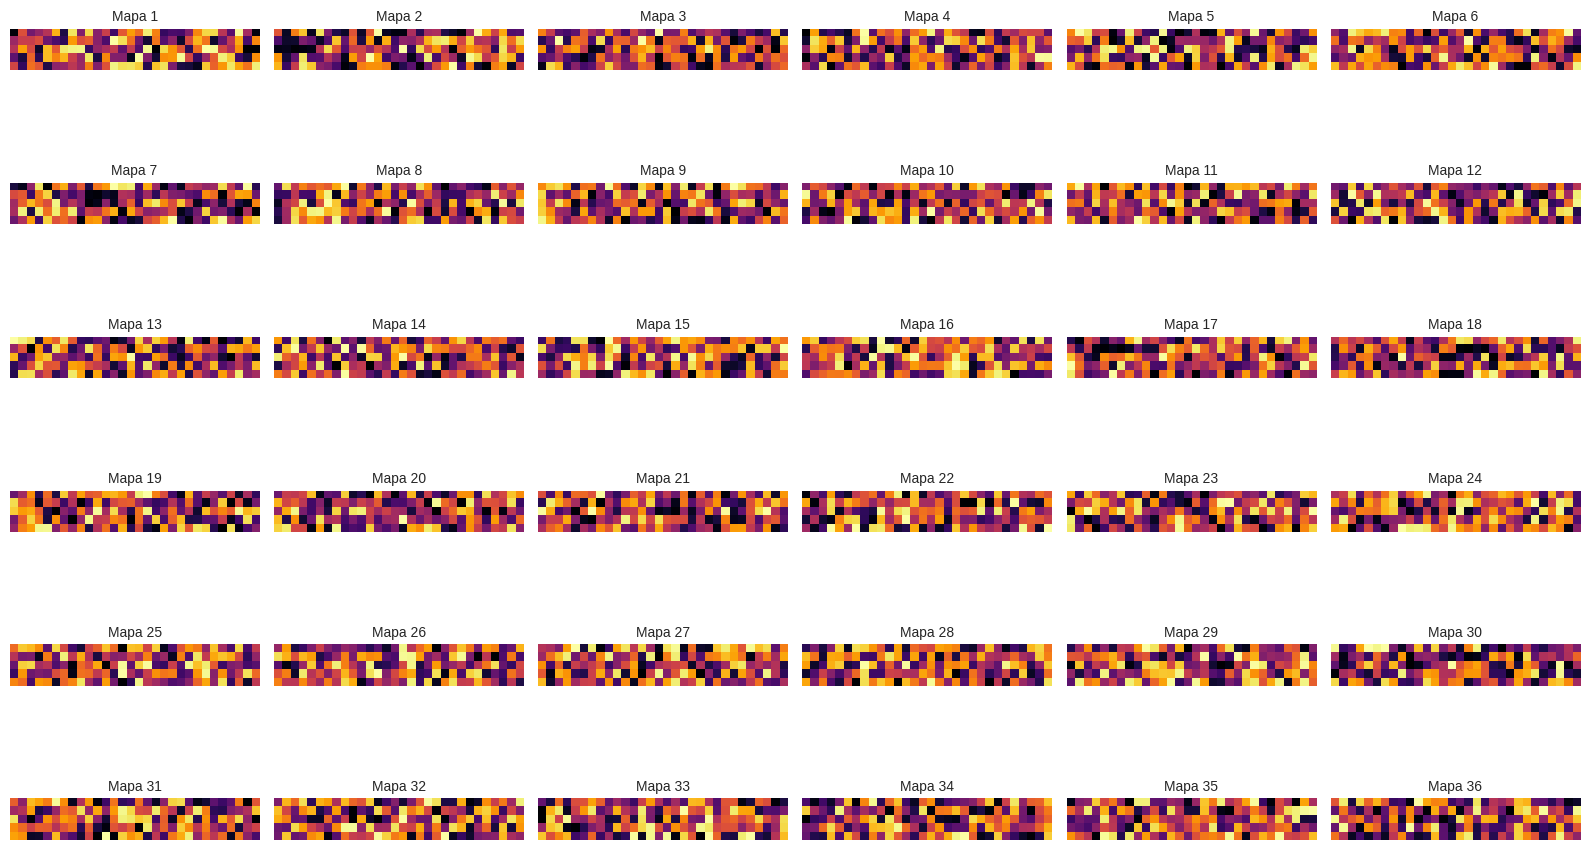

In [33]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
n_cols = 6
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(n_rows, n_cols, height_ratios=[1]*n_rows, width_ratios=[6]*n_cols)

for i in range(n_rows * n_cols):
    row, col = divmod(i, n_cols)
    ax = fig.add_subplot(gs[row, col])
    data = np.random.rand(5, 30)
    ax.imshow(data, aspect='equal', cmap='inferno')
    ax.axis('off')
    ax.set_title(f"Mapa {i+1}", fontsize=10)

plt.tight_layout()


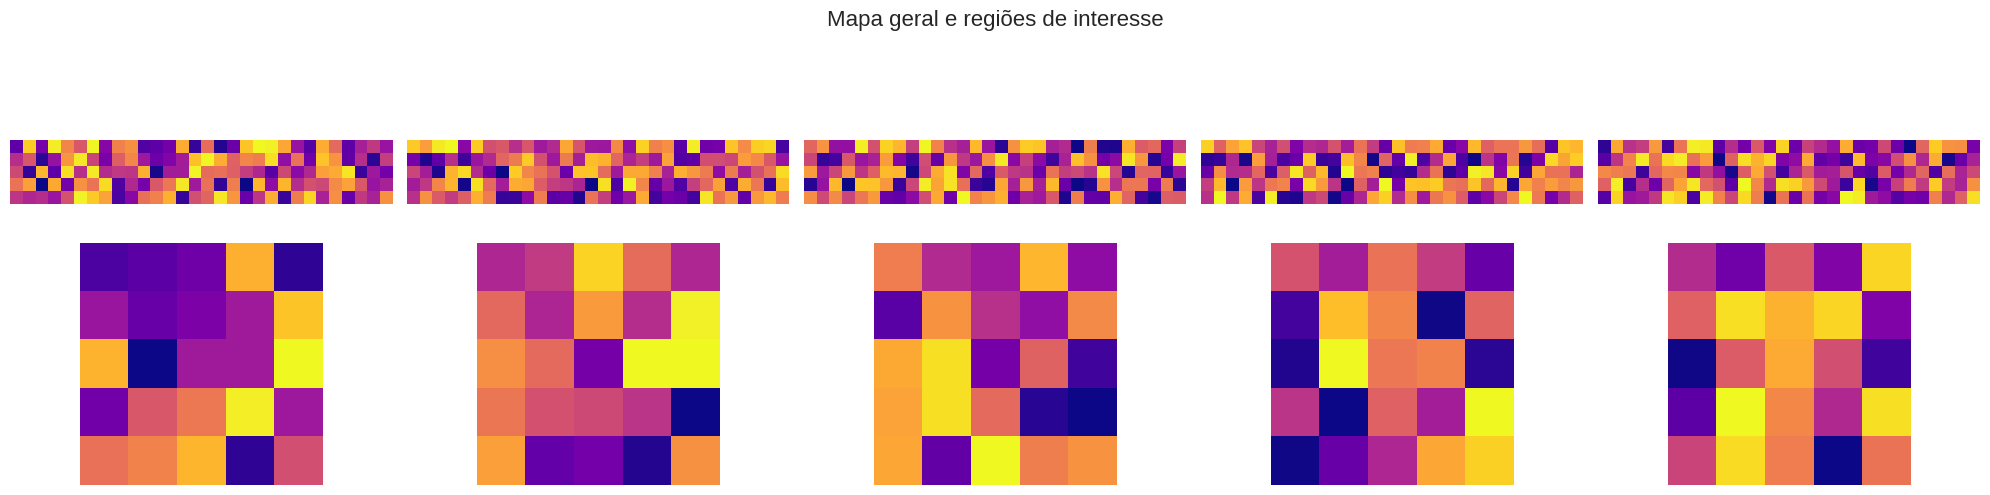

In [34]:
fig, axs = plt.subplots(2, 5, figsize=(20, 5))
for i in range(5):
    data = np.random.rand(5, 30)
    axs[0, i].imshow(data, aspect='equal', cmap='plasma')
    axs[0, i].axis('off')
    
    # Zoom na coluna 10 a 15
    axs[1, i].imshow(data[:, 10:15], aspect='equal', cmap='plasma')
    axs[1, i].axis('off')

fig.suptitle("Mapa geral e regiões de interesse", fontsize=16)
plt.tight_layout()


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

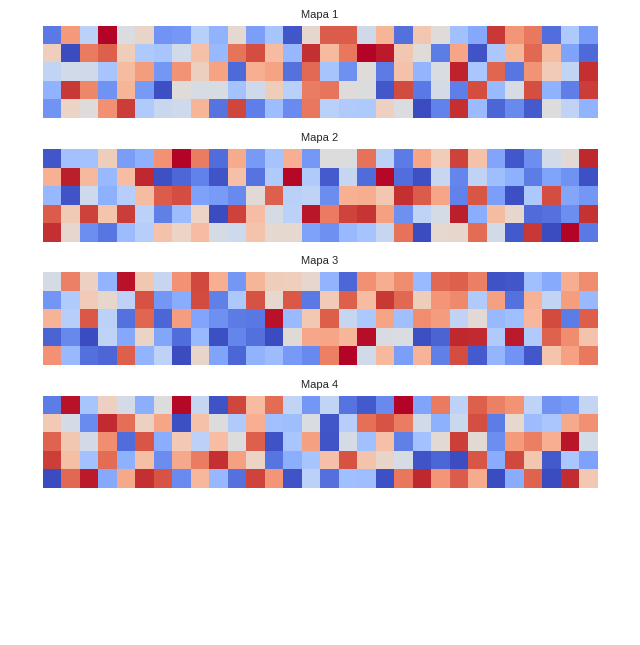

In [35]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(8, 8))

for i in range(4):
    inset = inset_axes(ax, width="90%", height="15%", loc='upper center',
                       bbox_to_anchor=(0, -i * 0.2, 1, 1), bbox_transform=ax.transAxes)
    data = np.random.rand(5, 30)
    inset.imshow(data, aspect='equal', cmap='coolwarm')
    inset.set_title(f"Mapa {i+1}", fontsize=8)
    inset.axis('off')

ax.axis('off')
